# Sections
1. Data Ingestion
2. Summary Statistics
3. Data Cleaning and Preprocessing
4. Visualization
5. Performing different tests (Word it better) {Correlation analysis, Dickey Fuller test, ADF, etc.}
6. Conclusions

7. Experimenting with different models

## Importing required libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import seaborn as sns
sns.set()
from statsmodels.tsa.seasonal import seasonal_decompose as decompose
from pandas import Series

# 1. Data Ingestion

The study consists of data for two cities: __*San Juan*__ and __*Iquitos*__

The dataset consists of two parts
* __dengue_features_train.csv__ : Contains readings for all the factors considered in the study (like humidity, temperature, etc.)
* __dengue_labels_train.csv__ : Contains the number of Dengue cases reported on a weekly basis.

In [2]:
env = 'VSCode'#'Colab'
path = '.'

if env == 'Colab':
    from google.colab import drive
    drive.mount('/content/drive')
    !ls drive/MyDrive/Dataset
    path = 'drive/MyDrive'

features = pd.read_csv(f'{path}/Dataset/dengue_features_train.csv')
features.week_start_date = pd.to_datetime(features.week_start_date) # Converting the date into a date time object

cases = pd.read_csv(f'{path}/Dataset/dengue_labels_train.csv')

# Performing an Inner Join on the dataset on the common columns
df = pd.merge(features, cases, on = ["year", "weekofyear", "city"])
df.index = df.week_start_date
df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-04-30,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1990-05-07,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
1990-05-14,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
1990-05-21,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
1990-05-28,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


## Counting number of rows and columns in the dataset

In [3]:
print(f"Number of attributes: {len(df.columns)}")
print(f"Number of rows {len(df)}")

Number of attributes: 25
Number of rows 1456


## As our dataset consists of two different cities, we will perform analysis on each city separately.

In [4]:
sj_df = df[df["city"] == 'sj']
sj_df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-04-30,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1990-05-07,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
1990-05-14,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
1990-05-21,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
1990-05-28,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [5]:
iq_df = df[df["city"] == 'iq']
iq_df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
week_start_date,,,,,,,,,,,,,,,,,,,,,
2000-07-01,iq,2000,26,2000-07-01,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,...,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0,0
2000-07-08,iq,2000,27,2000-07-08,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,...,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6,0
2000-07-15,iq,2000,28,2000-07-15,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,...,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1,0
2000-07-22,iq,2000,29,2000-07-22,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,...,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0,0
2000-07-29,iq,2000,30,2000-07-29,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,...,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0,0


In [6]:
datasets = {"San Juan" : sj_df, "Iquitos" : iq_df}

# 2. Summary Statistics

In [7]:
sj_df.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,936.000000,936.000000,745.000000,887.000000,917.000000,917.000000,927.000000,930.000000,930.000000,930.000000,...,930.000000,927.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,936.000000
mean,1998.826923,26.503205,0.057925,0.067469,0.177655,0.165956,35.470809,299.163653,299.276920,295.109519,...,78.568181,35.470809,16.552409,2.516267,27.006528,6.757373,31.607957,22.600645,26.785484,34.180556
std,5.212076,15.021909,0.107153,0.092479,0.057166,0.056073,44.606137,1.236429,1.218637,1.569943,...,3.389488,44.606137,1.560923,0.498892,1.415473,0.835993,1.717297,1.506277,29.325811,51.381372
min,1990.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,295.938571,296.114286,289.642857,...,66.735714,0.000000,11.715714,1.357143,22.842857,4.528571,26.700000,17.800000,0.000000,0.000000
25%,1994.000000,13.750000,0.004500,0.016425,0.139283,0.129157,0.000000,298.195000,298.300000,293.847857,...,76.246071,0.000000,15.236429,2.157143,25.842857,6.200000,30.600000,21.700000,6.825000,9.000000
50%,1999.000000,26.500000,0.057700,0.068075,0.177186,0.165971,20.800000,299.254286,299.378571,295.464286,...,78.667857,20.800000,16.845714,2.457143,27.228571,6.757143,31.700000,22.800000,17.750000,19.000000
75%,2003.000000,39.250000,0.111100,0.115200,0.212557,0.202771,52.180000,300.132857,300.228571,296.418929,...,80.963214,52.180000,17.858571,2.800000,28.185714,7.285714,32.800000,23.900000,35.450000,37.000000
max,2008.000000,53.000000,0.493400,0.437100,0.393129,0.381420,390.600000,302.200000,302.164286,297.795714,...,87.575714,390.600000,19.440000,4.428571,30.071429,9.914286,35.600000,25.600000,305.900000,461.000000


In [8]:
iq_df.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,520.000000,520.000000,517.000000,517.000000,517.000000,517.000000,516.000000,516.000000,516.000000,516.000000,...,516.000000,516.000000,516.000000,516.000000,483.000000,483.000000,506.000000,512.000000,504.000000,520.000000
mean,2005.000000,26.503846,0.263869,0.238783,0.250126,0.266779,64.245736,297.869538,299.133043,295.492982,...,88.639117,64.245736,17.096110,9.206783,27.530933,10.566197,34.004545,21.196680,62.467262,7.565385
std,2.918283,15.029450,0.081370,0.076751,0.077354,0.086345,35.218995,1.170997,1.332073,1.417229,...,7.583889,35.218995,1.445769,2.448525,0.921769,1.535496,1.325261,1.260327,63.245958,10.765478
min,2000.000000,1.000000,0.061729,0.035860,0.029880,0.064183,0.000000,294.635714,294.892857,290.088571,...,57.787143,0.000000,12.111429,3.714286,21.400000,5.200000,30.100000,14.700000,0.000000,0.000000
25%,2002.750000,13.750000,0.200000,0.179540,0.194743,0.204129,39.105000,297.092500,298.221429,294.593929,...,84.295000,39.105000,16.102857,7.371429,27.000000,9.500000,33.200000,20.600000,17.200000,1.000000
50%,2005.000000,26.500000,0.263643,0.232971,0.249800,0.262143,60.470000,297.822857,299.121429,295.852143,...,90.917143,60.470000,17.428571,8.964286,27.600000,10.625000,34.000000,21.300000,45.300000,5.000000
75%,2007.250000,39.250000,0.319971,0.293929,0.302300,0.325150,85.757500,298.649286,300.123214,296.548571,...,94.563929,85.757500,18.180357,11.014286,28.100000,11.655000,34.900000,22.000000,85.950000,9.000000
max,2010.000000,53.000000,0.508357,0.454429,0.538314,0.546017,210.830000,301.637143,302.928571,298.450000,...,98.610000,210.830000,20.461429,16.028571,30.800000,15.800000,42.200000,24.200000,543.300000,116.000000


## 2.1 Missing Data

In [9]:
for city in datasets:
    print(city)
    nullVals = datasets[city].isnull()
    nullValCounts = nullVals.sum()
    print(dict(nullValCounts))
    print(f"\nFraction of data missing per column:\n{dict(nullValCounts / len(datasets[city]))}\n")
    print(f"Total Missing data = {nullValCounts.sum()}")
    print(f"Total Duplicated data = {datasets[city].duplicated().sum()}")
    print(f"Total Incomplete data = {nullVals.any(axis = 1).sum()}")
    print("------------------------------------------\n")

San Juan
{'city': 0, 'year': 0, 'weekofyear': 0, 'week_start_date': 0, 'ndvi_ne': 191, 'ndvi_nw': 49, 'ndvi_se': 19, 'ndvi_sw': 19, 'precipitation_amt_mm': 9, 'reanalysis_air_temp_k': 6, 'reanalysis_avg_temp_k': 6, 'reanalysis_dew_point_temp_k': 6, 'reanalysis_max_air_temp_k': 6, 'reanalysis_min_air_temp_k': 6, 'reanalysis_precip_amt_kg_per_m2': 6, 'reanalysis_relative_humidity_percent': 6, 'reanalysis_sat_precip_amt_mm': 9, 'reanalysis_specific_humidity_g_per_kg': 6, 'reanalysis_tdtr_k': 6, 'station_avg_temp_c': 6, 'station_diur_temp_rng_c': 6, 'station_max_temp_c': 6, 'station_min_temp_c': 6, 'station_precip_mm': 6, 'total_cases': 0}

Fraction of data missing per column:
{'city': 0.0, 'year': 0.0, 'weekofyear': 0.0, 'week_start_date': 0.0, 'ndvi_ne': 0.20405982905982906, 'ndvi_nw': 0.05235042735042735, 'ndvi_se': 0.0202991452991453, 'ndvi_sw': 0.0202991452991453, 'precipitation_amt_mm': 0.009615384615384616, 'reanalysis_air_temp_k': 0.00641025641025641, 'reanalysis_avg_temp_k': 0.006

## 2.2 Outliers
Box-Plots to visualize outliers in the number of cases for both the cities

In [ ]:
# Box plot for every year
plt.rcParams["figure.figsize"] = 24, 15
fig, axs = plt.subplots(2, 1)

# Number of cases every year
sj_df.boxplot(by = 'year', column = ['total_cases'], ax = axs[0])
axs[0].set_title("Yearly cases in San Juan", size = 24)

iq_df.boxplot(by = "year", column = ["total_cases"], ax = axs[1])
axs[1].set_title("Yearly cases in Iquitos", size = 24)

plt.show()

# 4. Visualization

## 4.1 Line Plots

### 4.1.1 Line plot to vizualize `Number of cases vs time`, `Humidity vs time` and `temperature vs time`

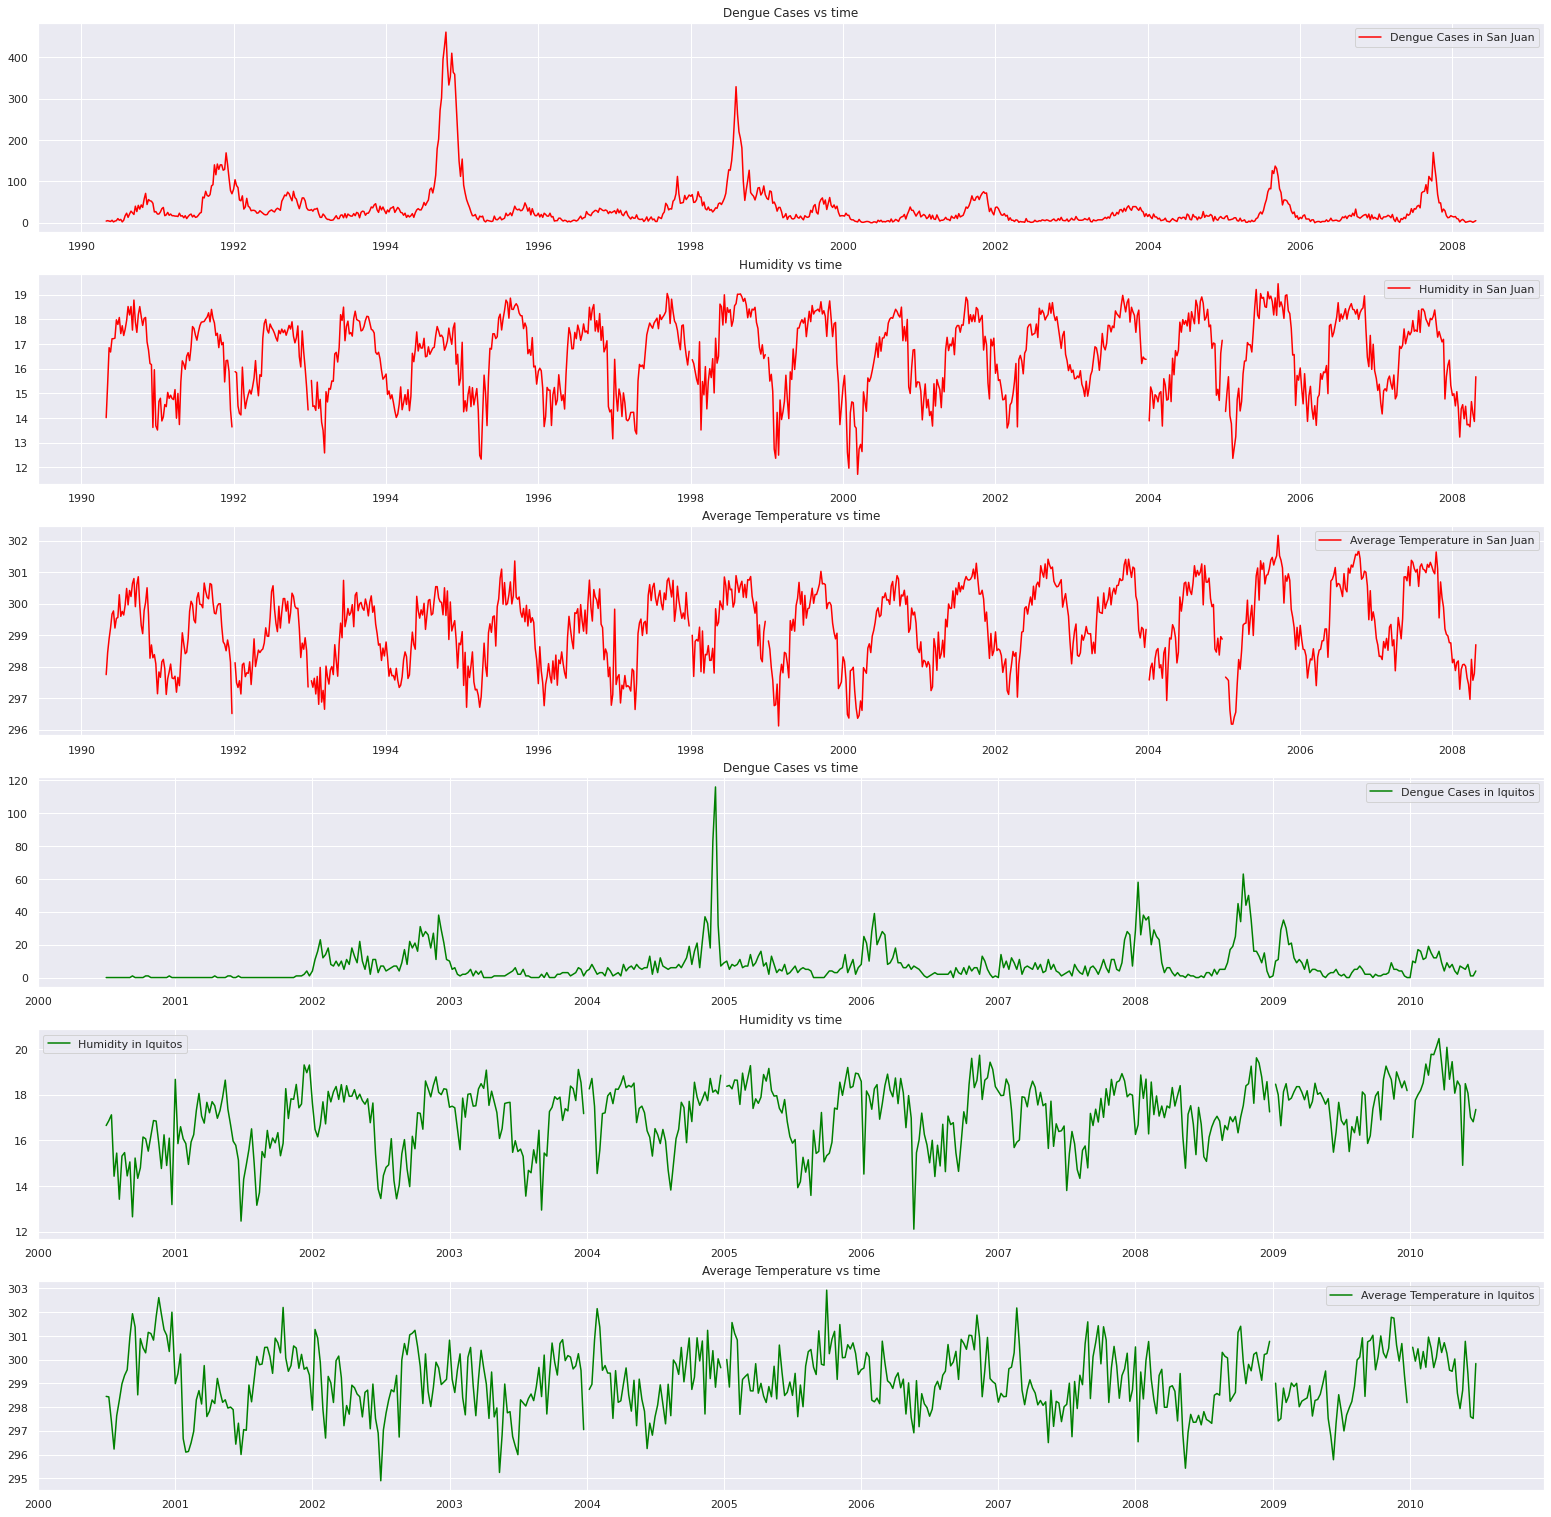

In [10]:
all_concerns = [
  'total_cases',
  'reanalysis_specific_humidity_g_per_kg',
  'reanalysis_avg_temp_k'
]

labels = [
  'Dengue Cases',
  'Humidity',
  'Average Temperature'
]

colors = ["red", "green"]

plt.rcParams['figure.figsize'] = (27, 27) #rc -> runtime config
fig,ax = plt.subplots(len(all_concerns) * len(datasets), 1) 

for index, city in enumerate(datasets):
  for i,concern in enumerate(all_concerns):
    ax[i + index*len(all_concerns)].plot(
        datasets[city].index,
        datasets[city][concern],
        color = colors[0 + index],
        label = f"{labels[i]} in {city}"
    )
    ax[i + index*len(all_concerns)].set_title(f"{labels[i]} vs time")
    ax[i + index*len(all_concerns)].legend()

plt.show()

### 4.1.2 Finding the number of yearly cases for the cities sj and iq

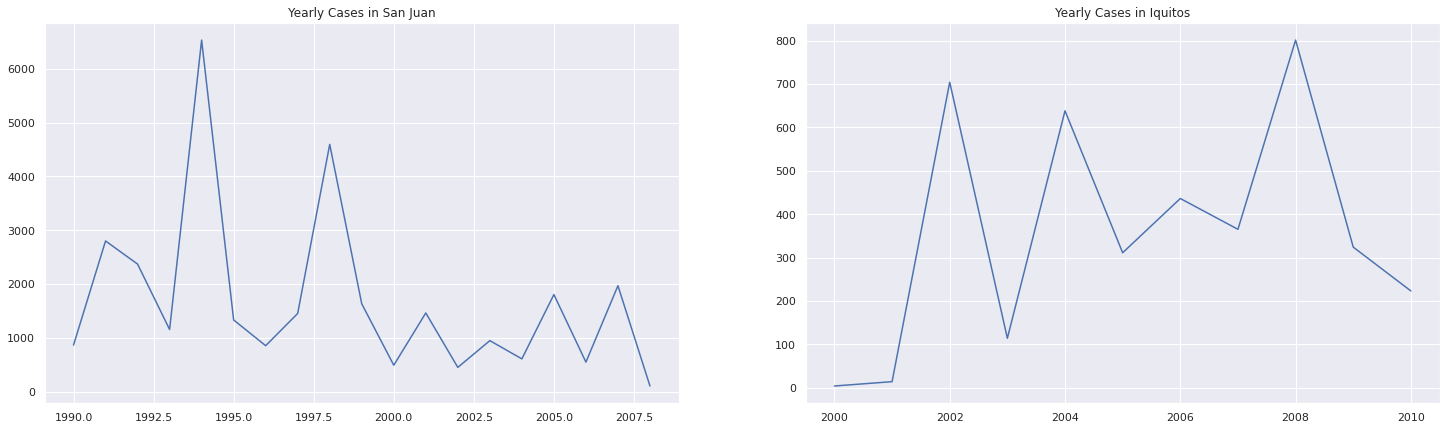

In [11]:
sj_df_yearly = pd.DataFrame(
    {
        "year" : np.unique(sj_df['year']),
        "total_cases" : sj_df.groupby(["year"])["total_cases"].sum()
    }
)

iq_df_yearly = pd.DataFrame(
    {
        "year" : np.unique(iq_df['year']),
        "total_cases" : iq_df.groupby(["year"])["total_cases"].sum()
    }
)

plt.rcParams['figure.figsize'] = (25, 7) #rc -> runtime config
fig, axs = plt.subplots(1, 2) 

axs[0].plot(sj_df_yearly.year, sj_df_yearly.total_cases)
axs[0].set_title("Yearly Cases in San Juan")

axs[1].plot(iq_df_yearly.year, iq_df_yearly.total_cases)
axs[1].set_title("Yearly Cases in Iquitos")

plt.show()

## 4.2 Histograms
Understanding the distribution of data for `total number of cases, specific humidity and air temperature in both cities`

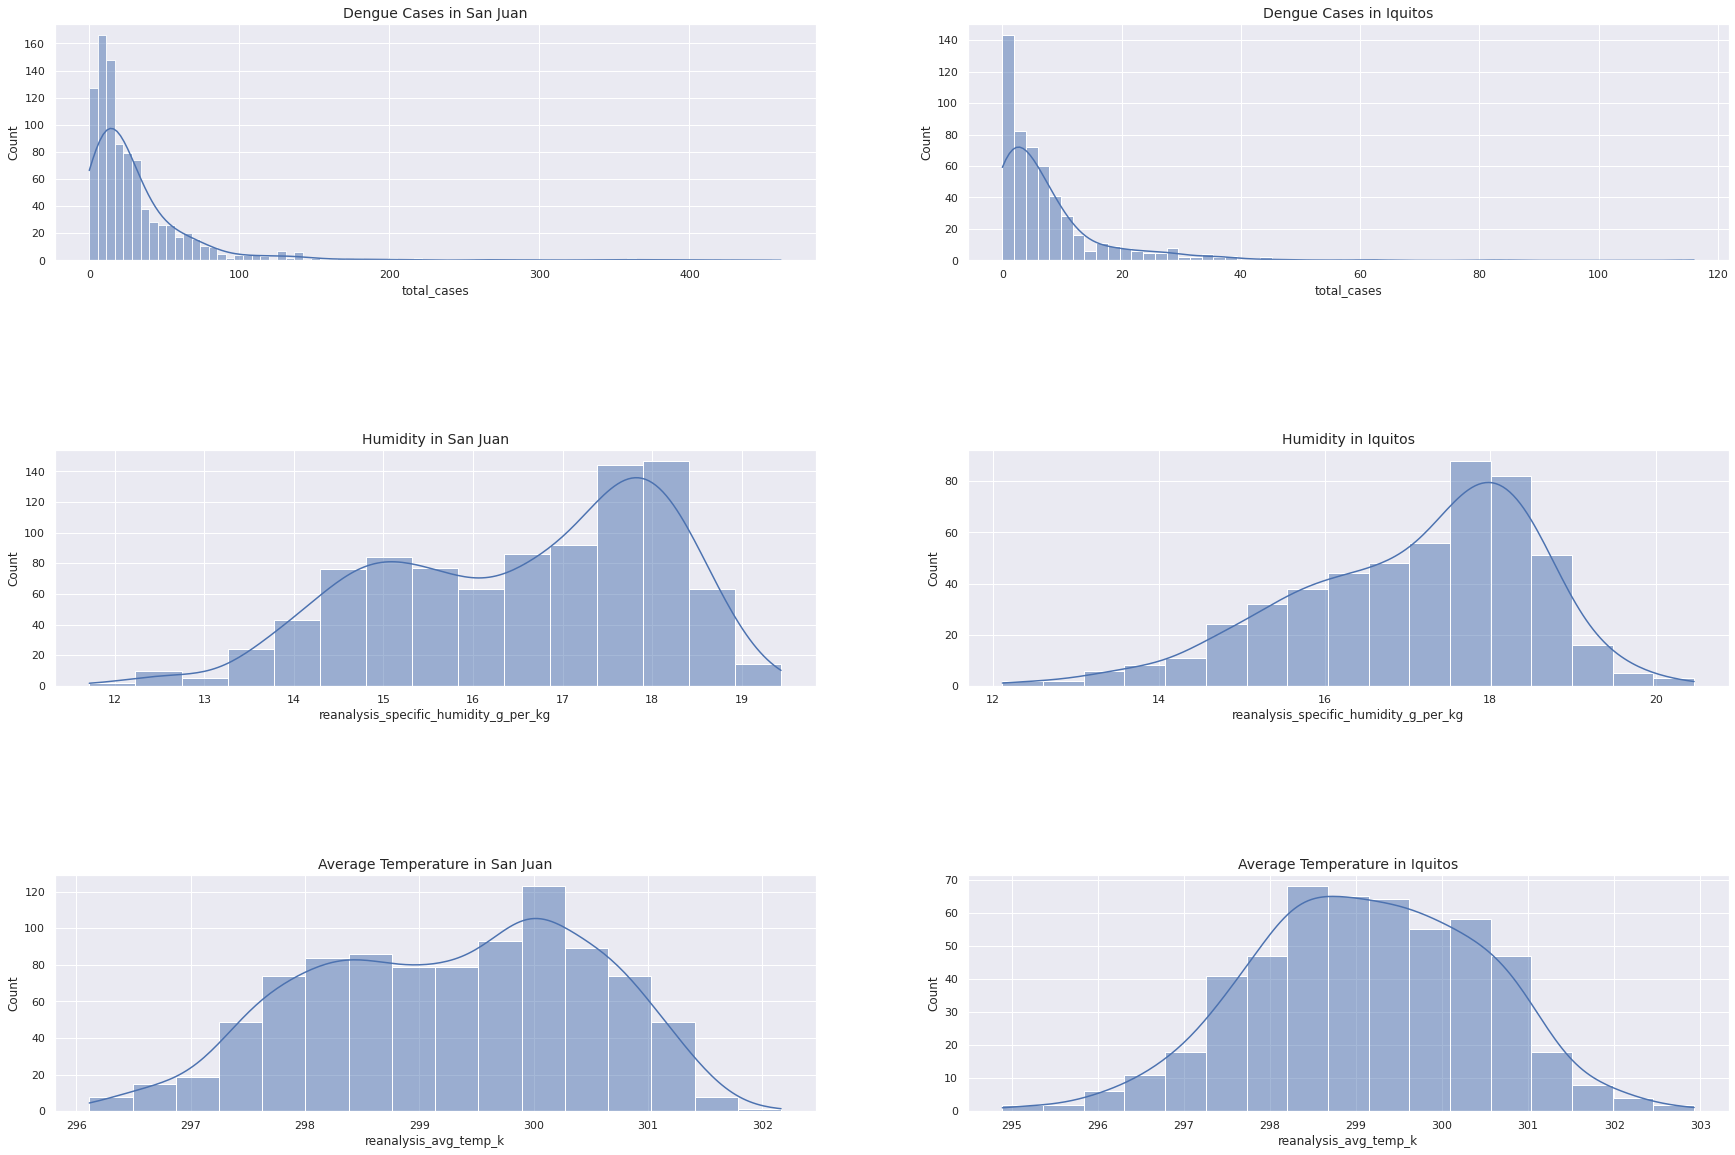

In [12]:
all_concerns = [
  'total_cases',
  'reanalysis_specific_humidity_g_per_kg',
  'reanalysis_avg_temp_k'
]

labels = [
  'Dengue Cases',
  'Humidity',
  'Average Temperature'
]

plt.rcParams["figure.figsize"] = 30, 20
fig, axs = plt.subplots(len(all_concerns), len(datasets)) 
plt.subplots_adjust(hspace = 0.8) #space between plots

for index, city in enumerate(datasets):
    for i,concern in enumerate(all_concerns):
        sns.histplot(datasets[city][concern], ax = axs[i, index], kde = True)
        axs[i, index].set_title(f"{labels[i]} in {city}",size=14)
        

plt.show()

## 4.3 Correlation matrices

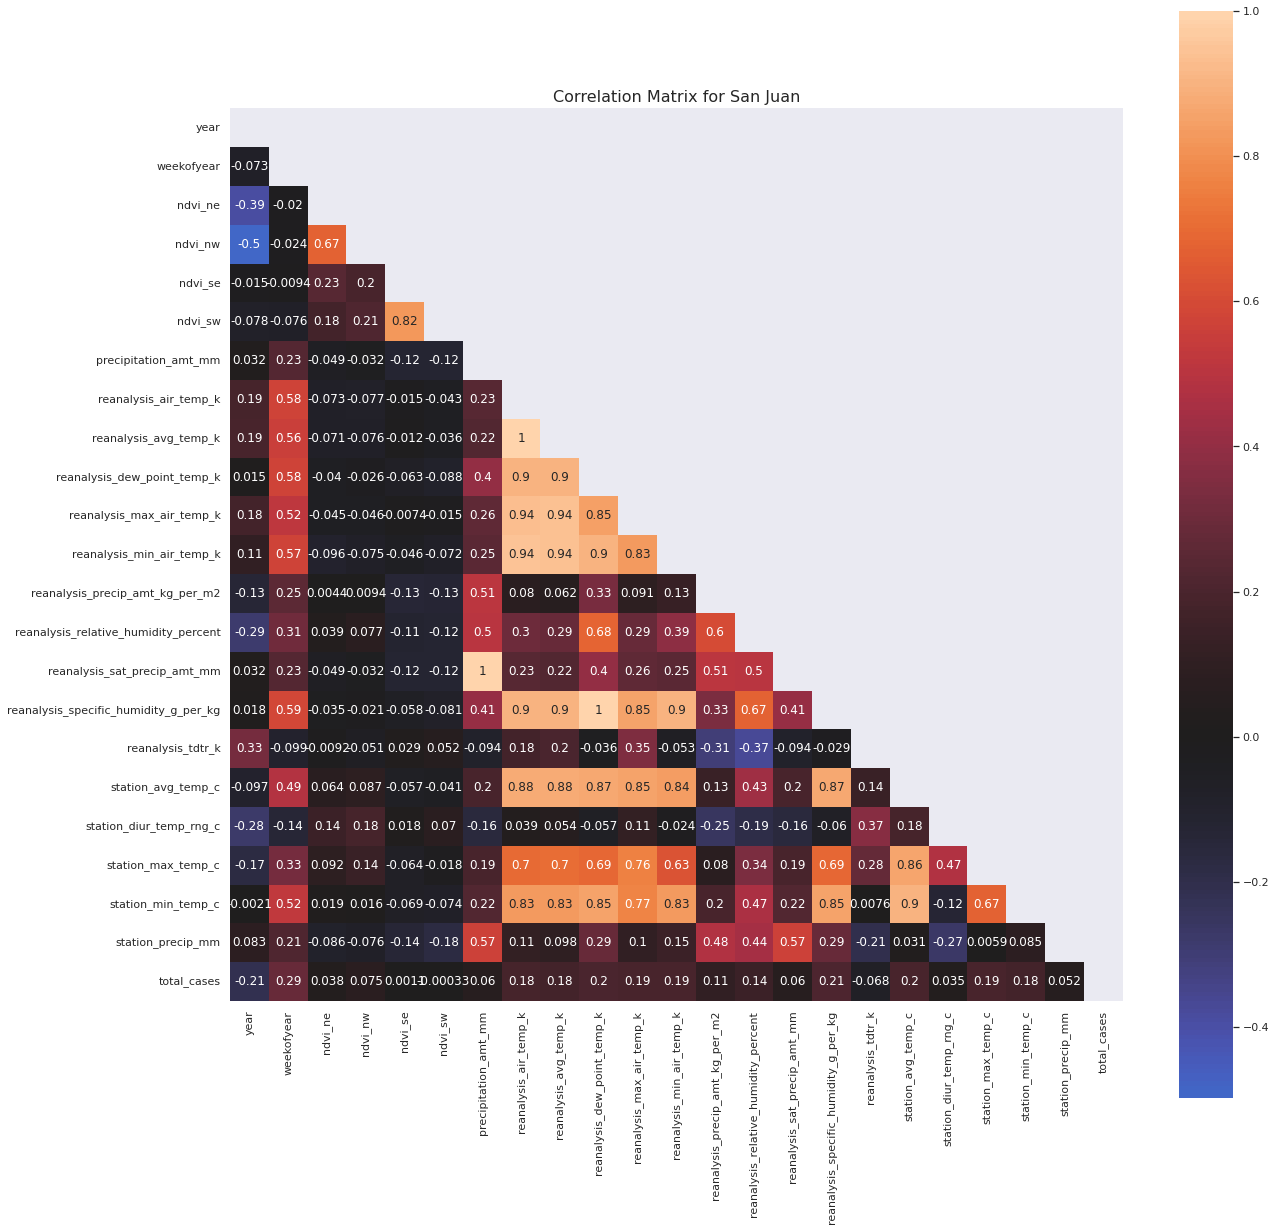

In [13]:
corr_cases = sj_df.corr()
mask = np.triu(np.ones_like(corr_cases, dtype=bool)) # Generate a mask for the upper triangle

f, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(corr_cases, mask = mask, center = 0, square = True, annot = True)
plt.title('Correlation Matrix for San Juan', fontsize = 16)
plt.show()

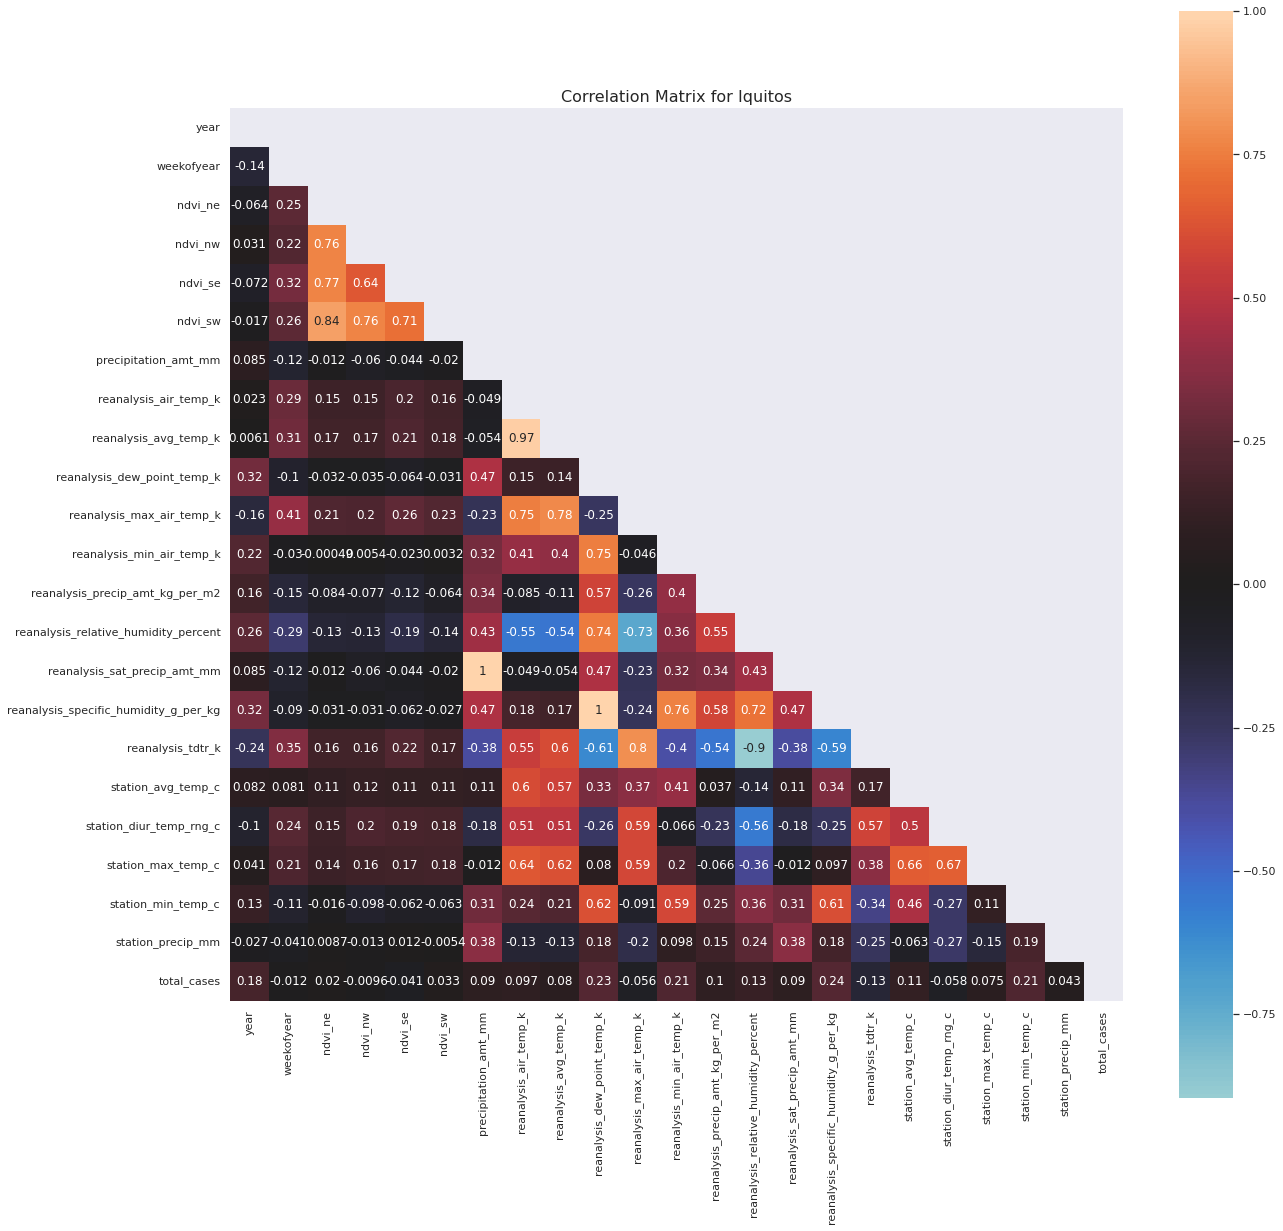

In [14]:
corr_cases = iq_df.corr()
mask = np.triu(np.ones_like(corr_cases, dtype=bool)) # Generate a mask for the upper triangle

f, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(corr_cases, mask = mask, center = 0, square = True, annot = True)
plt.title('Correlation Matrix for Iquitos', fontsize = 16)
plt.show()